# Machine Learning Analysis: Predicting Global News Attention

###  Objective
The goal of this section is to determine **which national indicators best predict a country's media coverage**. We treat this as a regression problem.

###  Data Preprocessing & Feature Engineering
To ensure our models perform well on this skewed dataset, we applied the following transformations:
1.  **Target ($y$):** `Log(News Frequency)` — Applied to handle the "Power Law" distribution of news coverage.
2.  **GDP:** `Log(GDP)` — Standard log-transformation to normalize economic data.
3.  **Military Power:** `Log(1 / PowerIndex)` — **Inverted and Log-Transformed**.
    * *Reason:* The raw PowerIndex is counter-intuitive (lower = stronger) and exponential. We inverted it so "Higher = Stronger" and log-transformed it to fix the skew.
4.  **Scaling:** All features were scaled using `StandardScaler` to ensure fair comparison.

###  Validation Strategy
Given our small dataset size (~150 countries), we use **Leave-One-Out Cross-Validation (LOOCV)**. We train on **$N-1$** countries and test on the remaining **1**, repeating this for every country to get a robust accuracy score.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load & Preprocess
df = pd.read_csv('final_complete_dataset.csv')
df_clean = df.dropna()
y = np.log1p(df_clean['Frequency'])
X_all = df_clean[['Average_GDP_Last_10_Years_Billion_USD', 'Average_Democracy_Score', 'PowerIndex', 'Average_FSI_Total_Score']].copy()
X_all['Log_GDP'] = np.log1p(X_all['Average_GDP_Last_10_Years_Billion_USD'])
X_all = X_all.drop(columns=['Average_GDP_Last_10_Years_Billion_USD'])
X_all['Log_Inverse_Power'] = np.log1p(1 / (X_all['PowerIndex'] + 1e-6))
X_all = X_all.drop(columns=['PowerIndex']) 


scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=X_all.columns)
loo = LeaveOneOut()

###  Feature Correlation Analysis

Before training our predictive models, it is crucial to examine the **linear relationships** between our features and the target variable (`Log_Frequency`).

**Why check correlation on *transformed* data?**
We are calculating correlations using the **log-transformed** versions of GDP and Military Power, rather than the raw data.
* **Reason:** Raw GDP and News Frequency both follow exponential "Power Laws." Their raw correlation might be weak, but their *log-log* correlation is often very strong. This is the relationship our models will actually "see" and learn from.

**What to look for in the Heatmap:**
1.  **Target Correlation:** Look at the `Log_Frequency` row/column.
    * **High Red (> 0.5):** Strong positive driver (e.g., "Rich countries get more news").
    * **High Blue (< -0.5):** Strong negative driver.
2.  **Multicollinearity:** Check the intersection of **Economic** and **Military**.
    * If they are highly correlated with *each other* (e.g., > 0.7), it implies "Rich countries have strong militaries." This explains why models might struggle to distinguish between them (one variable "steals" the importance from the other).

Saved plot to correlation_matrix.png


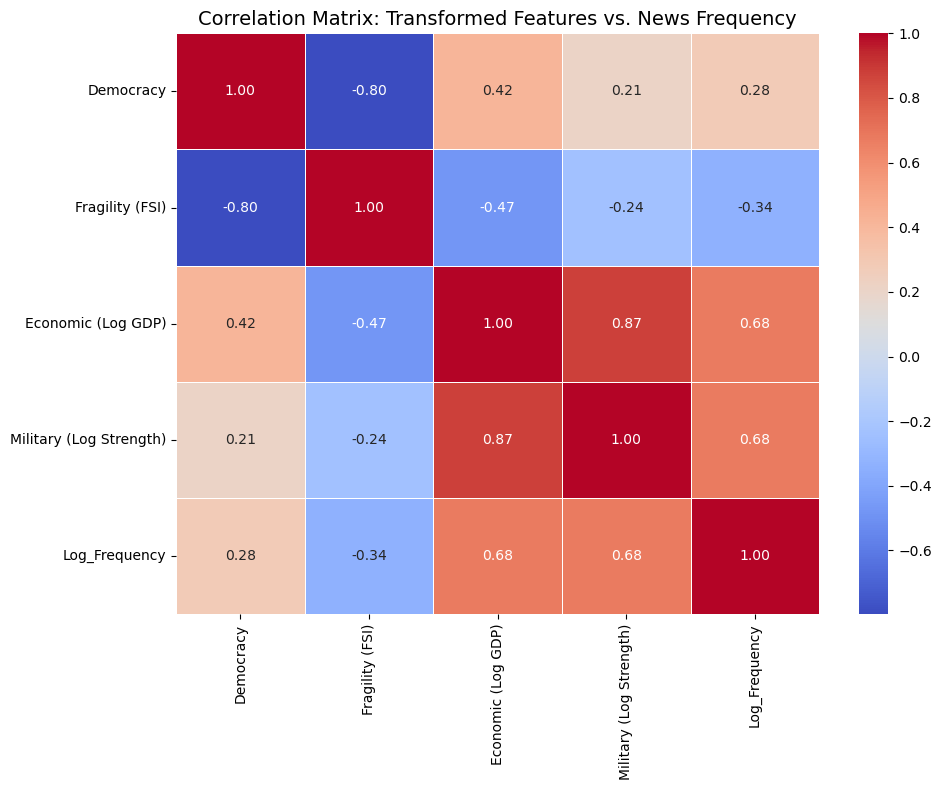

--- Correlation with News Frequency ---
Log_Frequency              1.000000
Economic (Log GDP)         0.676294
Military (Log Strength)    0.676288
Democracy                  0.280549
Fragility (FSI)           -0.336050
Name: Log_Frequency, dtype: float64


In [ ]:
# === NEW SECTION: CORRELATION ANALYSIS ===
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create a temporary dataframe with all Transformed Features + Target
# We want to see how features correlate with 'Log_Frequency' (y)
df_corr = X_all.copy()
df_corr['Log_Frequency'] = y  # Add target

# 2. Rename columns for cleaner plot labels
df_corr = df_corr.rename(columns={
    'Average_Democracy_Score': 'Democracy',
    'Average_FSI_Total_Score': 'Fragility (FSI)',
    'Log_Inverse_Power': 'Military (Log Strength)',
    'Log_GDP': 'Economic (Log GDP)'
})

# 3. Calculate Correlation Matrix
corr_matrix = df_corr.corr()

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Transformed Features vs. News Frequency", fontsize=14)
plt.tight_layout()

plt.savefig('correlation_matrix.png', dpi=300)
print("Saved plot to correlation_matrix.png")

plt.show()

# 5. Print specific correlations with the Target
print("--- Correlation with News Frequency ---")
print(corr_matrix['Log_Frequency'].sort_values(ascending=False))

Because of high correlation between GDP and military, I created additional dataframes here for comparisons. 

In [41]:
X_without_military = X_all.drop(columns=['Log_Inverse_Power']) # drop 
X_without_GDP = X_all.drop(columns=['Log_GDP'])
X_without_military_scaled = pd.DataFrame(scaler.fit_transform(X_without_military), columns=X_without_military.columns)
X_without_GDP_scaled = pd.DataFrame(scaler.fit_transform(X_without_GDP), columns=X_without_GDP.columns)


### Model A: Linear Regression (Baseline)
We start with a standard Linear Regression model to test for simple, direct relationships between our variables and news coverage.

#### Model A.1 : (Using Both GDP and Military)
We start by including both to get a base value.

Linear Regression (both variables) RMSE: 0.6693
Linear Regression (both variables) R2: 0.4615
Saved plot to linear_regression_all_results.png


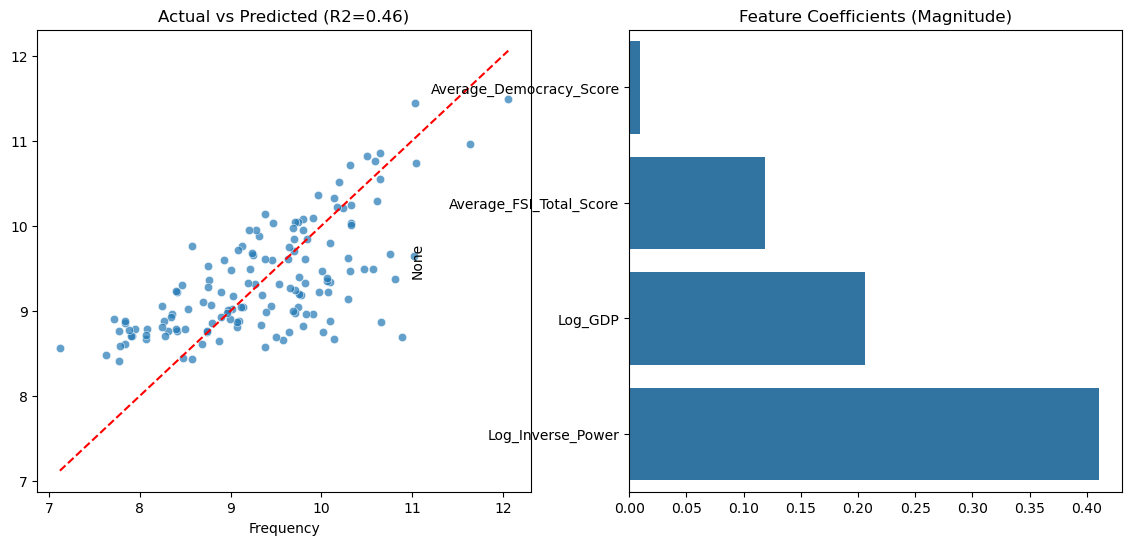

In [37]:
model = LinearRegression()
y_pred = cross_val_predict(model, X_all_scaled, y, cv=loo)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"Linear Regression (both variables) RMSE: {rmse:.4f}")
print(f"Linear Regression (both variables) R2: {r2:.4f}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y, y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title(f"Actual vs Predicted (R2={r2:.2f})")

plt.subplot(1, 2, 2)
model.fit(X_all_scaled, y)
sns.barplot(x=np.abs(model.coef_), y=X_all.columns)
plt.title("Feature Coefficients (Magnitude)")
plt.savefig('linear_regression_all_results.png', dpi=300)
print("Saved plot to linear_regression_all_results.png")
plt.show()

#### Model A.2 : (Military excluded)
Now, get the results when we exclude the military.

Linear Regression (military excluded) RMSE: 0.6897
Linear Regression (military excluded) R2: 0.4281
Saved plot to linear_regression_without_military_results.png


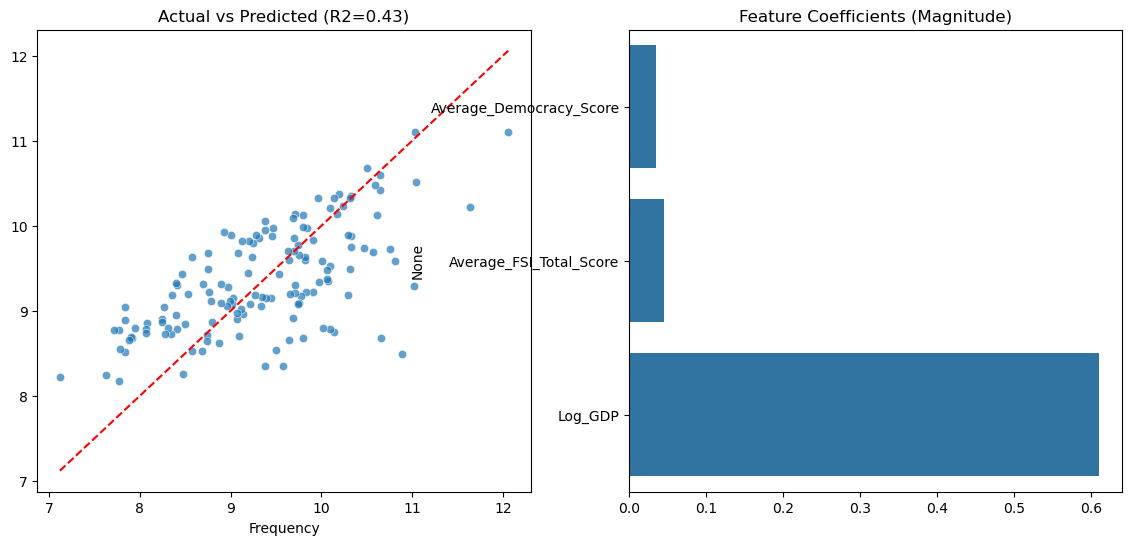

In [39]:
model = LinearRegression()
y_pred = cross_val_predict(model, X_without_military_scaled, y, cv=loo)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"Linear Regression (military excluded) RMSE: {rmse:.4f}")
print(f"Linear Regression (military excluded) R2: {r2:.4f}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y, y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title(f"Actual vs Predicted (R2={r2:.2f})")

plt.subplot(1, 2, 2)
model.fit(X_without_military_scaled, y)
sns.barplot(x=np.abs(model.coef_), y=X_without_military_scaled.columns)
plt.title("Feature Coefficients (Magnitude)")
plt.savefig('linear_regression_without_military_results.png', dpi=300)
print("Saved plot to linear_regression_without_military_results.png")
plt.show()

#### Model A.3 : (GDP excluded)
Now, get the results when we exclude the GDP.

Linear Regression (GDP excluded) RMSE: 0.6684
Linear Regression (GDP excluded) R2: 0.4629
Saved plot to linear_regression_without_GDP_results.png


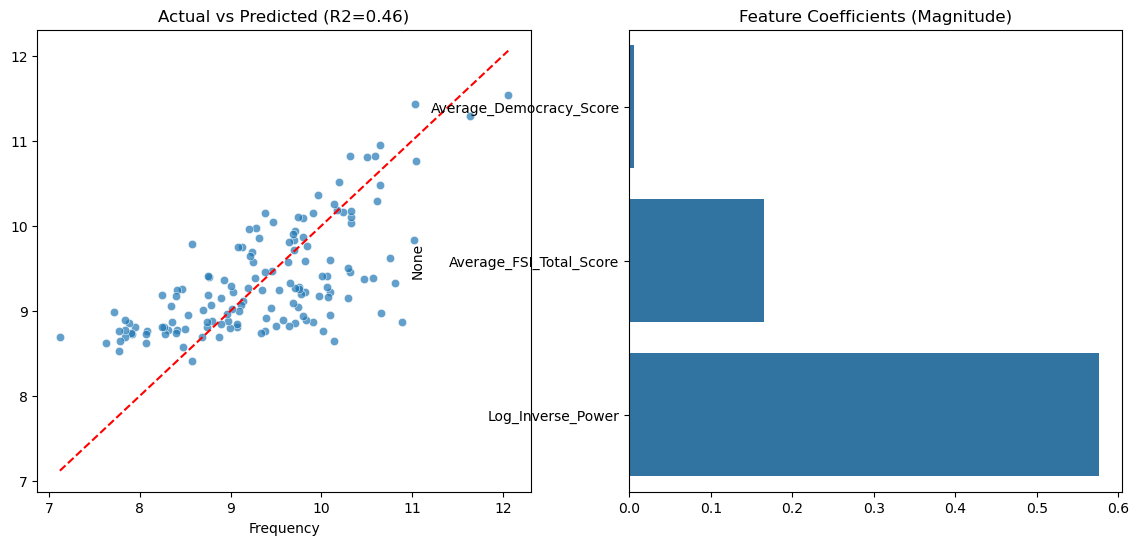

In [40]:
model = LinearRegression()
y_pred = cross_val_predict(model, X_without_GDP_scaled, y, cv=loo)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"Linear Regression (GDP excluded) RMSE: {rmse:.4f}")
print(f"Linear Regression (GDP excluded) R2: {r2:.4f}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y, y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title(f"Actual vs Predicted (R2={r2:.2f})")

plt.subplot(1, 2, 2)
model.fit(X_without_GDP_scaled, y)
sns.barplot(x=np.abs(model.coef_), y=X_without_GDP_scaled.columns)
plt.title("Feature Coefficients (Magnitude)")
plt.savefig('linear_regression_without_GDP_results.png', dpi=300)
print("Saved plot to linear_regression_without_GDP_results.png")
plt.show()

####  Interim Result: Linear Model Comparison

Before moving to complex models, let's quickly check which Linear Regression variation performed best:

* **Model A.2 (GDP excluded):** Performed the best.  RMSE: 0.6684 , R2: 0.4629
* **Model A.1 (Both)** Performed slightly worse.      RMSE: 0.6693 , R2: 0.4615
* **Model A.3 (Military excluded):** Performed worst. RMSE: 0.6897 , R2: 0.4281

**Next Step:**
Now that we know the "Military-Only" Linear model is our current champion, we will test **Random Forest** and **Gradient Boosting** to see if they can beat it.

### Model B: Random Forest Regressor
Next, we use a Random Forest model. This algorithm can capture **non-linear** patterns (e.g., if Democracy only matters when GDP is high) but is more prone to overfitting on small datasets.

Random Forest RMSE: 0.7132
Random Forest R2: 0.3884
Saved plot to random_forest_results.png


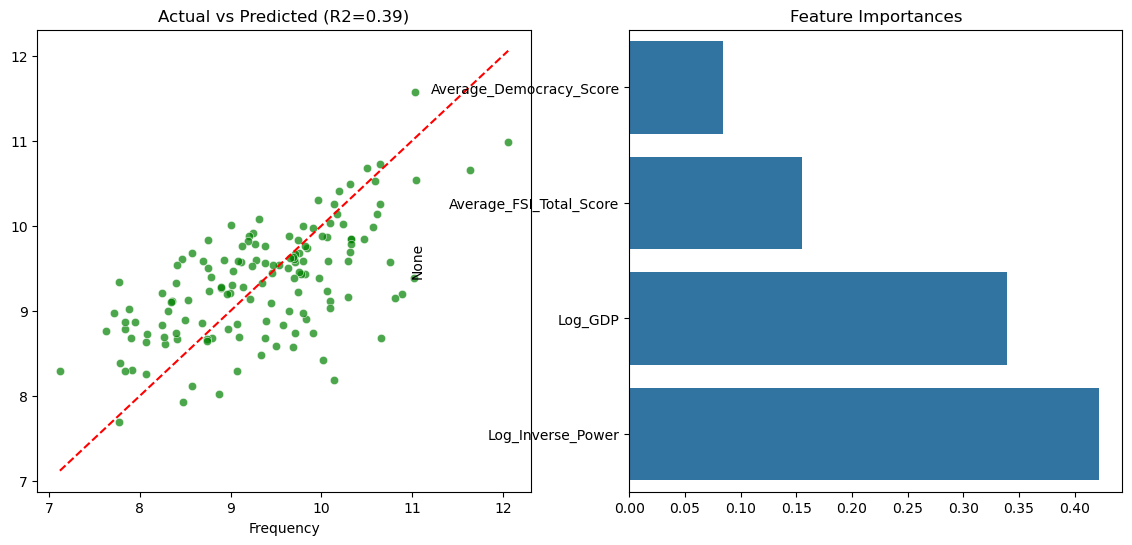

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred = cross_val_predict(model, X_all_scaled, y, cv=loo)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"Random Forest RMSE: {rmse:.4f}")
print(f"Random Forest R2: {r2:.4f}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y, y=y_pred, alpha=0.7, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title(f"Actual vs Predicted (R2={r2:.2f})")

plt.subplot(1, 2, 2)
model.fit(X_all_scaled, y)
sns.barplot(x=model.feature_importances_, y=X_all.columns)
plt.title("Feature Importances")
plt.savefig('random_forest_results.png', dpi=300)
print("Saved plot to random_forest_results.png")
plt.show()

### Model C: Gradient Boosting
Finally, we test Gradient Boosting. This is an iterative method that attempts to correct the errors of previous trees, often providing high accuracy but requiring careful tuning.

Gradient Boosting RMSE: 0.7802
Gradient Boosting R2: 0.2683
Saved plot to gradient_boosting_results.png


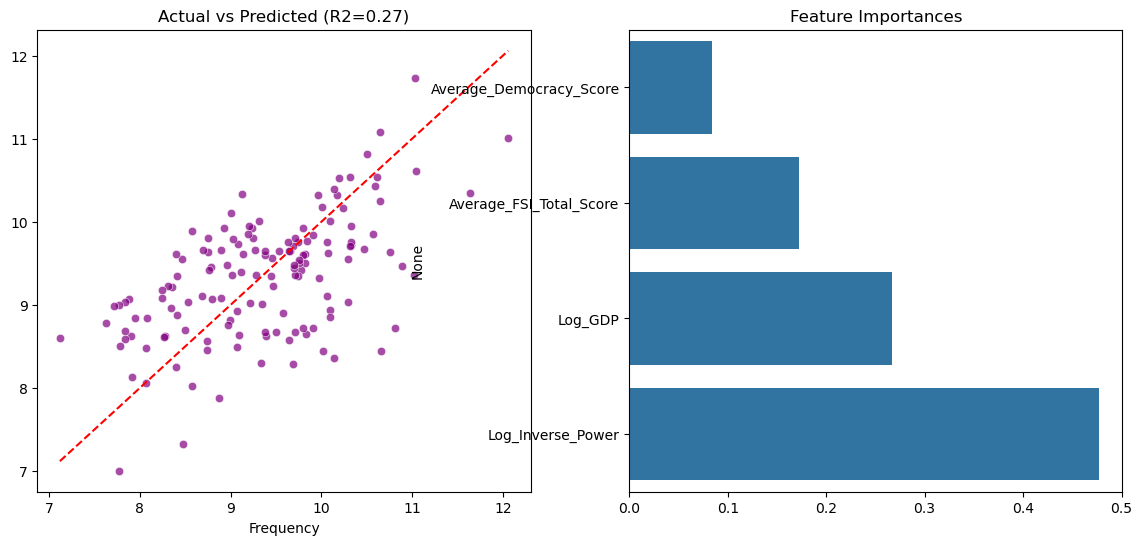

In [ ]:
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
y_pred = cross_val_predict(model, X_all_scaled, y, cv=loo)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"Gradient Boosting RMSE: {rmse:.4f}")
r2 = r2_score(y, y_pred)
print(f"Gradient Boosting R2: {r2:.4f}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y, y=y_pred, alpha=0.7, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title(f"Actual vs Predicted (R2={r2:.2f})")

plt.subplot(1, 2, 2)
model.fit(X_all_scaled, y)
sns.barplot(x=model.feature_importances_, y=X_all.columns)
plt.title("Feature Importances")
plt.savefig('gradient_boosting_results.png', dpi=300)
print("Saved plot to gradient_boosting_results.png")
plt.show()

# Results & Comparative Analysis

Now that we have trained all three models, let's compare their performance using two key metrics: **RMSE** and **$R^2$**.

###  Understanding the Metrics

#### 1. Root Mean Squared Error (RMSE)
* **What it measures:** The average "distance" between the model's prediction and the actual value.
* **Interpretation:** **LOWER is BETTER.**
    * Since our target is `Log(Frequency)`, an RMSE of **0.67** means the model's predictions are typically off by a factor of $e^{0.67} \approx 1.9$.
    * A lower RMSE means the model is making smaller mistakes on average.
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

#### 2. R-Squared ($R^2$)
* **What it measures:** The percentage of variance in news coverage that the model explains compared to just guessing the average.
* **Interpretation:** **HIGHER is BETTER.**
    * **$1.0$ (100%):** Perfect prediction.
    * **$0.0$ (0%):** No better than random guessing.
    * **$0.40 - 0.60$:** Considered a strong result in social science, where human/political behavior always contains randomness.

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

---

###  The Verdict

| Model | RMSE (Error) $\downarrow$ | $R^2$ Score (Accuracy) $\uparrow$ | Interpretation |
| :--- | :--- | :--- | :--- |
| **Linear Regression (exclude GDP)** | **0.6684** (Lowest) | **0.4629** (Highest) | **Winner.**  |
| **Linear Regression(both GDP and military)** | 0.6693 | 0.4615|**Slightly Lower.** Adding GDP introduced noise/redundancy.    |
| **Linear Regression(exclude military)** | 0.6897  | 0.4281|**Considerably worse than other LG models** Economic wealth alone is a weaker predictor.    |
| **Random Forest** | 0.7132 | 0.3884 | **Overfitting.** The model tried to find complex rules that didn't exist, hurting its test performance. |
| **Gradient Boosting** | 0.7802 (Highest) | 0.2683 (Lowest) | **Overfitting.** The model was too complex for the small sample size (~150 countries). |


### Scientific Conclusion

Our Ablation Study yielded a decisive result: **The "Military Focus" model outperformed both the "GDP Focus" model and the "Combined" model.**

#### 1. The Primacy of Hard Power (Security > Wealth)
The fact that **Model A.2 (Military)** defeated **Model A.3 (GDP)** confirms that the global diplomatic network is driven primarily by **Security Realism**. The world pays attention to nations that can project force. While economic power is important, it generates significantly less "news frequency" than military capacity.

#### 2. The "Shadow" of Wealth (Why GDP was Redundant)
Crucially, adding GDP to the Military model (Model A.1) **did not improve performance**.
* **Interpretation:** This suggests that GDP is merely a *prerequisite* for Military Power. Wealthy nations build strong militaries, but it is the **Military Capability itself** that drives the attention.
* **The Lesson:** A rich nation with no military presence (e.g., small wealthy states) receives far less attention than a militarized power.

#### 3. Linearity & The Power Law
The consistent failure of non-linear models (Random Forest/Boosting) to beat Linear Regression confirms that the relationship is **straightforward and exponential**. There are no hidden, complex non-linear rules—Global Attention follows a strict **Power Law hierarchy** defined by Hard Power.